# Measurement of Quality Factor on Cavities
Woks better if you adjust manually the delay on the instrumemt.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from HelpModule import *
from E5080B_driver import *
from SGS100A_driver import *
from spirack import SPI_rack, S4g_module
from IPython.display import clear_output
from time import sleep
import fitting as fit

from importlib import reload

In [2]:
twpa_on = False
vna = E5080B_driver('TCPIP0::192.168.0.235::inst0::INSTR')
vna.open()

if twpa_on:
    twpa = SGS100A_driver('TCPIP0::192.168.0.34::inst0::INSTR')
    twpa.open()

In [3]:
from datetime import datetime

params={}
params['test_date'] = datetime.today().strftime('%Y%m%d_%H%M')
params['test_type'] = 'resonatorquality'
params['qubit_name'] = 'Cavity3_etched'
params['twpa_on'] = twpa_on
params['vna_power'] = -60   #<-----------------------------
params['center_freq'] = 4.610098e9
params['span_freq'] = 5 #In MHz
params['flux_curr'] = 0
params['temp'] = 24.4
params['comment'] = "Cavity Quality Factor Measuremnt before Annealing \n" +\
                    "# After Annealing " +\
                    "# " +\
                    "# Connection Diagram: NA" +\
                    "# \n"
npoints = 20001

if params['twpa_on']:
    twpa.set_RF(params['twpa_frequency'])
    twpa.set_level(params['twpa_power']) # dBm

In [4]:
#First update the position of the resonance freq
import HelpModule  as help
reload(help)

meas = 'S12'
format = 'MA'

freqs, mag, phase = meas_spectrum(vna, f_c = params['center_freq'], f_span = params['span_freq'], power = params['vna_power'], 
                                  sleep_t = 100, npoints = npoints, data_format = format, meas = meas)
vna.autoscale()

f_c, Qf, fwhm = help.Q2(freqs,20*np.log10(mag), format='DB', plot_f=True) # Measured on trasmission 

print('Quality Factor: %2.3f'%Qf)
print('3dB BW: %2.3f kHz'%(fwhm*1e-3))
print('f_c: %2.5f GHz'%(f_c*1e-9))



<class 'Exception'>


IndexError: index 0 is out of bounds for axis 0 with size 0

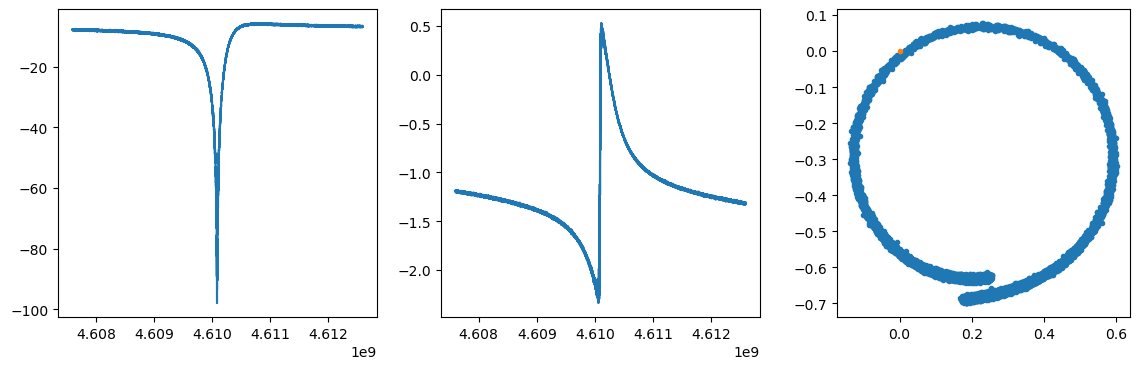

In [7]:
import matplotlib.gridspec as gridspec

angle_rad = np.unwrap(phase*np.pi/180)-np.pi*0.0


s21_complex = np.array(mag*np.exp(1j*angle_rad),dtype=np.complex128)#dtype = # 128-bit complex floating-point number

#Plot
fig = plt.figure(figsize=(14, 4))
gs = gridspec.GridSpec(1, 3)
gs.update(wspace=0.2)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])



ax1.plot(freqs, 20*np.log(np.abs(s21_complex)))
ax2.plot(freqs, np.unwrap(np.angle(s21_complex)))

ax3.plot(s21_complex.real,s21_complex.imag,'.') #add the data
ax3.plot(0,0,'.') #add the origin (0,0) point
ax3.set_aspect('equal')

plt.show()

$$
    S_{21}(\omega) =  A \cdot \left( 1- \frac{Q/Q_e \cdot e^{i \phi}}{1+2iQ\frac{\omega-\omega_c}{\omega_c}} \right)
    \left( 1+\alpha\frac{\omega-\omega_c}{\omega_c}   \right)
    e^{j(\phi_v \cdot \omega + \phi_0)}

$$

8835.768752159547
Parameters([('f_c', <Parameter 'f_c', value=4610090000.0, bounds=[-inf:inf]>), ('Q', <Parameter 'Q', value=8835.768752159547, bounds=[100.0:2305045.0]>), ('Qe', <Parameter 'Qe', value=10000.0, bounds=[0:1000000.0]>), ('A', <Parameter 'A', value=1, bounds=[-inf:inf]>), ('slope', <Parameter 'slope', value=0.0, bounds=[-inf:inf]>), ('theta', <Parameter 'theta', value=0.0, bounds=[-1.5707963267948966:1.5707963267948966]>), ('phi_v', <Parameter 'phi_v', value=0.0, bounds=[-inf:inf]>), ('phi_v0', <Parameter 'phi_v0', value=288.0, bounds=[-inf:inf]>), ('A0', <Parameter 'A0', value=1.0, bounds=[-inf:inf]>)])


{'f_c': 4610182534.386907, 'Q': 9475.66053100916, 'Qe': 9015.549725329753, 'A': 3.341070670656571, 'slope': -18.66334044597269, 'theta': -0.3677505615878516, 'phi_v': -6.301449700685325e-08, 'phi_v0': 967.8298278628087, 'Qi': 492532.9502114407, 'fwhm': 486528.8830578148, 'kc': 0.5113590047020993}


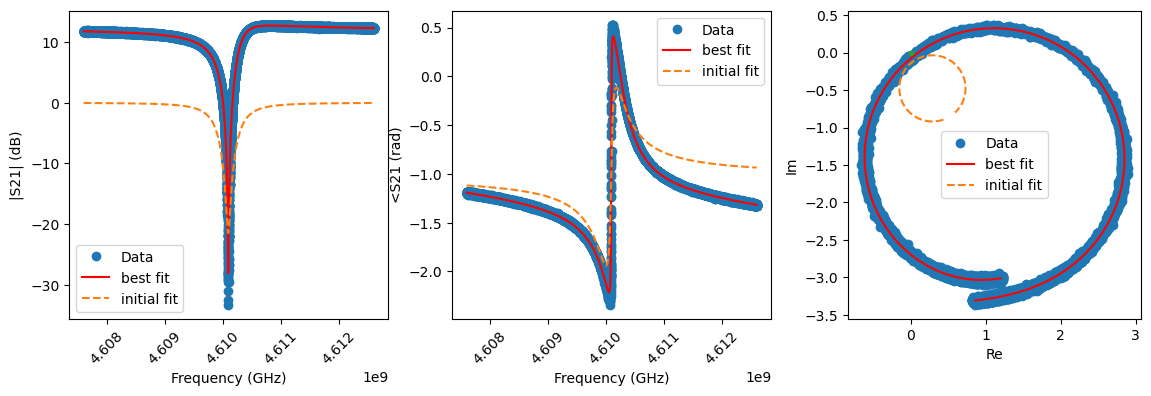

In [190]:
from importlib import reload
reload(fit)
f_c = 4.61009e9

A = max(mag)
                 
s21_complex = np.array((mag)*np.exp(1j*(angle_rad)),dtype=np.complex128)#dtype = # 128-bit complex floating-point number

#Unwind phase
tau = 0. #electrical delay in ns (first guess from VNA measure)
phi0 = np.pi/2
zdata = np.array(s21_complex*np.exp(1j*freqs*tau*1e-9*2*np.pi+phi0),dtype=np.complex128)

#f_c, fwhm, Q, offset = fit.lorentzian_fit(s21_complex,freqs,report = True, plot = True ) 
fspan = int(len(freqs)/2)
mspan = int(len(freqs)/2)
fit_params = fit.circle_fit(freqs, zdata, f_c = f_c ,fwhm =521753.1297288931)


9984

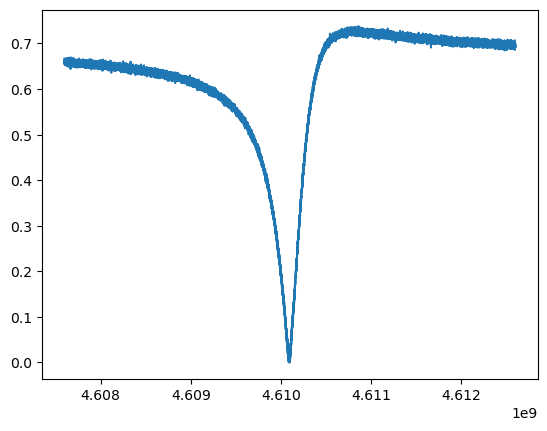

In [95]:

bw = min(mag)*2

z2 = abs(mag-bw)
plt.plot(freqs,z2)
z2.argmin()

In [21]:
header_str = get_plot_str(params)
filename = params['test_type'] +"_"+params['qubit_name'] + "_" +params['test_date']
np.savez("./data/"+filename,
         header = header_str,
         freqs=freqs,
         mags=mag,
         phases=phase)
print('file saved as %s'%filename)

file saved as resonatorquality_R2401_R1_20240524_1216


In [ ]:
vna.autoscale()

In [23]:
from importlib import reload
import qfoundry_fit
reload(qfoundry_fit)

tau =0.0e-12 #025e-12 #electrical delay in ns (first guess from VNA measure)
s21 = np.array(s21_complex*np.exp(1j*tau*freqs*2*np.pi),dtype=np.complex128)

_, results = qfoundry_fit.fit_resonance_complex(freqs[500:1500], s21[500:1500], model = "transmission", plot= True,f_c=f_c, fwhm=fwhm)

# to see the resukts you can call each as results['Q'] and so, or to get all of them:
for name, val in results.items():
    print(name + " = %f"%val)

ModuleNotFoundError: No module named 'qfoundry_fit'

In [ ]:
print(A)

0.229247197509
